In [1]:
# Importing libraries
import numpy as np

import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, HTML

from scipy.optimize import curve_fit
from scipy.constants import c, G, astronomical_unit as AU
from scipy.stats import t as t 

import time

from uncertainties import ufloat, unumpy as un, umath as um


In [2]:
# Plot settings
plt.rc("font", size=10)
plt.rcParams['font.family'] = 'Liberation Serif'
plt.rcParams["mathtext.default"] = "regular"

In [3]:
# Constants
M_sun = 1.9884e30  # kg

# Mercury parameters
M_mercury = 0.3301e24  # kg
T_mercury = 87.969  # days
semi_major_axis = 57.909e9  # meters
eccentricity = 0.2056

T_rel = 365.256 / T_mercury # Earth years per Mercury year

phi_teor = ufloat(43.03, 0.03) # arcseconds per century

In [4]:
# Calculating perehelion distans and initial velocity at perihelion using Kepler's equation
perihelion_distance = semi_major_axis * (1 - eccentricity)

print(f"perihelion_distance = {perihelion_distance:.2e} m")

v_perihelion = np.sqrt(G * M_sun * (1 + eccentricity) / (semi_major_axis * (1 - eccentricity)))

print(f"v_perihelion = {v_perihelion:.2e} m/s")

# Calculating base acceleration at perihelion
a_perihelion = G * M_sun / perihelion_distance**2

print(f"a_perihelion = {a_perihelion:.2e} m/s^2")

# Initial conditions
r0 = np.array([perihelion_distance, 0, 0])  # Mercury starts at perihelion
v0 = np.array([0, v_perihelion, 0])  # tangential velocity at perihelion

perihelion_distance = 4.60e+10 m
v_perihelion = 5.90e+04 m/s
a_perihelion = 6.27e-02 m/s^2


In [5]:
# Functions 
def linear_func(x, m, c):
    return m * x + c

def uncert(data_input, uncert_inst):
    t_coeff = t.ppf((1 + 0.6827)/2, len(data_input)-1)
    return np.sqrt((np.std(data_input)/np.sqrt(len(data_input)))**2 + uncert_inst**2)*t_coeff

def time_parameters(N_T, N_dt):
    T = N_T * T_mercury # iteractions in days
    dt = (2 * v_perihelion / a_perihelion) / 86400 / N_dt # days

    steps = int(T / dt)

    # print(f"Iteractionals time = {T/365.26:2f} years, dt = {dt:2f} days, N_steps = {steps}")
    
    return T, dt, steps

def acceleration(r, v, alpha, beta):
    r_mag = np.linalg.norm(r)  # calculating the magnitude of the position vector
    r_unit = r / r_mag  # unit vector in the direction of r
    
    # Calculating angular momentum squared term: (r vec * r vec dot)^2 / c^2
    L_squared = np.linalg.norm(np.cross(r, v))**2 / c**2
    
    # Calculating the relativistic correction factors
    correction_term = 1 + (alpha * 2 * G * M_sun) / (r_mag * c**2) + beta * L_squared / r_mag**2
    
    # Calculating the acceleration vector
    a = -G * M_sun / r_mag**2 * correction_term * r_unit

    # r_s = ((2 * G * M_sun) / c**2) / r_mag
    # r_L = L_squared / r_mag**2

    # print(f"r_s = {r_s:.2e}, r_L = {r_L:.2e}, L^2 = {L_squared:.2e}")
    
    return a 

def simulate_orbit(alpha, beta, N_T, N_dt):
    T, dt, steps = time_parameters(N_T, N_dt)
    
    r = np.zeros((steps, 3))
    v = np.zeros((steps, 3))
    
    r[0] = r0
    v[0] = v0
    
    for i in range(steps - 1):
        a = acceleration(r[i], v[i], alpha, beta)

        v[i+1] = v[i] + a * dt * 86400  # days to seconds
        r[i+1] = r[i] + v[i+1] * dt * 86400

    return r

def find_perihelion_positions(r):
    r_magnitude = np.linalg.norm(r, axis=1)
    perihelion_positions = [r[0]]  # starting with the initial perihelion
    uncertainties = []
    
    for i in range(1, len(r_magnitude) - 1):
        if r_magnitude[i] < r_magnitude[i - 1] and r_magnitude[i] < r_magnitude[i + 1]:
            perihelion_positions.append(r[i])
            uncertainty = abs(r_magnitude[i+1] - r_magnitude[i-1]) / 2  # approximation of positional uncertainty
            uncertainties.append(uncertainty)

    first_uncertainty = np.mean(uncertainties)
    uncertainties.insert(0, first_uncertainty)
    
    return np.array(perihelion_positions), np.array(uncertainties)

def calculating_perihelion_angles(positions , uncertainties):
    angles_val = []
    angles_err = []
    for i in range(1, len(positions)):
        position_x_1 = ufloat(positions[i-1][0], uncertainties[i-1])
        position_y_1 = ufloat(positions[i-1][1], uncertainties[i-1])

        position_x_2 = ufloat(positions[i][0], uncertainties[i])
        position_y_2 = ufloat(positions[i][1], uncertainties[i])

        phi = um.acos((position_x_1 * position_x_2 + position_y_1 * position_y_2) / (um.sqrt(position_x_1**2 + position_y_1**2) * um.sqrt(position_x_2**2 + position_y_2**2)))
        angles_val.append(um.degrees(phi).nominal_value)
        angles_err.append(um.degrees(phi).std_dev)

    average_precession = ufloat(np.mean(angles_val), uncert(angles_val, np.mean(angles_err)))

    return average_precession

def getting_angle_data(coeff, range_min, range_max, step, N_T, N_dt, plot=True):
    if coeff == 'alpha':
        alpha = 0
        beta = range(range_min, range_max, step)
        n_iteractions = len(beta)
    else:
        alpha = range(range_min, range_max, step)
        beta = 0
        n_iteractions = len(alpha)

    # Calculating angles
    angles = []
    angles_arcsec = []
    for i in tqdm(range(n_iteractions), desc="Calculaaaaaating"):
        if coeff == 'alpha':
            r = simulate_orbit(alpha, beta[i], N_T, N_dt)
        else:
            r = simulate_orbit(alpha[i], beta, N_T, N_dt)

        perihelion_positions, perihelion_uncertainties = find_perihelion_positions(r)

        average_precession = calculating_perihelion_angles(perihelion_positions, perihelion_uncertainties)

        angles.append(average_precession)

        if coeff == 'alpha':
            angles_arcsec.append(average_precession / beta[i] * 3 * 3600 * T_rel * 100)
        else:
            angles_arcsec.append(average_precession / alpha[i] * 3 * 3600 * T_rel * 100)

    # Fitting the data
    if coeff == 'alpha':
        x_data = beta
    else:
        x_data = alpha

    popt, pcov = curve_fit(linear_func, x_data, un.nominal_values(angles), sigma=un.std_devs(angles), absolute_sigma=True)

    slope, intercept = popt
    slope_err, intercept_err = np.sqrt(np.diag(pcov))

    slope_comp = ufloat(slope, slope_err)

    # Plotting the linear regression

    if plot:
        fig, ax = plt.subplots(figsize=(8, 8))

        if coeff == 'alpha':
            ax.set_xlabel(r'$\beta$')
        else:
            ax.set_xlabel(r'$\alpha$')

        ax.yaxis.label.set_fontsize(20)
        ax.set_ylabel(r'$\varphi ~\text{[deg]}$')
        ax.xaxis.label.set_fontsize(20)
        ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
        ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

        if coeff == 'alpha':
            ax.errorbar(beta, un.nominal_values(angles), yerr=un.std_devs(angles), fmt='o', markersize=5, capsize=5, color='blue', label='Angles')

            ax.plot(beta, linear_func(beta, slope, intercept), color='red', label=r'$\varphi(\beta) = $' + f'{slope_comp:.2e} ' + r'$\beta$ ' + f'[deg]')
        else:
            ax.errorbar(alpha, un.nominal_values(angles), yerr=un.std_devs(angles), fmt='o', markersize=5, capsize=5, color='blue', label='Angles')

            ax.plot(alpha, linear_func(alpha, slope, intercept), color='red', label=r'$\varphi(\alpha) = $' + f'{slope_comp:.2e} ' + r'$\alpha$ ' + f'[deg]')
            
        ax.legend(fontsize=15)

        plt.tight_layout()  
        plt.savefig(f'images/phi_{coeff}.png', bbox_inches='tight')
        plt.show()

    if coeff == 'alpha':
        return slope_comp, angles_arcsec, beta
    else:
        return slope_comp, angles_arcsec, alpha
    
def plotting_difference(coeff, angles, coeff_range, time):
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_xlabel(rf'$\{coeff}$')
    ax.yaxis.label.set_fontsize(20)
    ax.set_ylabel('Relative deviation')
    ax.xaxis.label.set_fontsize(20)
    ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
    ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
    ax.set_xscale('log')
    ax.set_ylim(0, 1)

    for i in range(len(angles)):
        # Calculating the absolute deviation from the theoretical value
        deviation = np.abs([angle - phi_teor for angle in angles[i]]) / phi_teor

        ax.fill_between(coeff_range[i], 0, un.nominal_values(deviation), color=colors[i], alpha=0.4, label=rf'$dt/{time[i]}$')

    ax.axvline(1.1e5, color='black', linestyle='--', linewidth=1, label=rf'$\{coeff}_{{\mathrm{{opt}}}} = 1.1e5$')
    
    ax.legend(fontsize=15)

    plt.tight_layout()  
    plt.savefig(f'images/phi_{coeff}_diff.png', bbox_inches='tight')
    plt.show()

def efficency_test(alpha, beta, N_T_list, N_dt_list):
    deviations_val = np.zeros((len(N_T_list), len(N_dt_list)))
    deviations_err = np.zeros((len(N_T_list), len(N_dt_list)))
    times = np.zeros((len(N_T_list), len(N_dt_list)))
    
    for j, N_T in enumerate(tqdm(N_T_list, desc="Processing N_T")):
        for i, N_dt in enumerate(tqdm(N_dt_list, desc=f"N_T = {N_T}", leave=False)):
            start_time = time.time()
            
            r = simulate_orbit(alpha, beta, N_T, N_dt)

            perihelion_positions, perihelion_uncertainties = find_perihelion_positions(r)

            average_precession = calculating_perihelion_angles(perihelion_positions, perihelion_uncertainties)

            average_precession_arcsec = average_precession / beta * 3 * 3600 * T_rel * 100
            
            computation_time = time.time() - start_time
            
            deviations_val[j, i] = (np.abs(average_precession_arcsec - phi_teor) / phi_teor).nominal_value

            deviations_err[j, i] = (np.abs(average_precession_arcsec - phi_teor) / phi_teor).std_dev

            times[j, i] = computation_time
    
    return deviations_val, deviations_err, times

In [22]:
# Setting up simulation parameters
N_T = 150
N_dt = 150

alpha = 0
beta = 1.1e5

# Runing simulation 
r = simulate_orbit(alpha, beta, N_T, N_dt)

# Calculating perihelion positions
perihelion_positions, perihelion_uncertainties = find_perihelion_positions(r)

# Calculating angles between successive perihelions
average_precession = calculating_perihelion_angles(perihelion_positions, perihelion_uncertainties)

average_precession_arcsec = average_precession / beta * 3 * 3600 * T_rel * 100

print(f"Average perihelion precession per century: {average_precession_arcsec} arcsec")

# Calculating the difference in percent
difference_percent = (average_precession_arcsec - phi_teor) / phi_teor * 100

print(f"Difference between average_precession_arcsec and phi_teor: {difference_percent:.2f}%")

Average perihelion precession per century: 43.11+/-0.33 arcsec
Difference between average_precession_arcsec and phi_teor: 0.19+/-0.77%


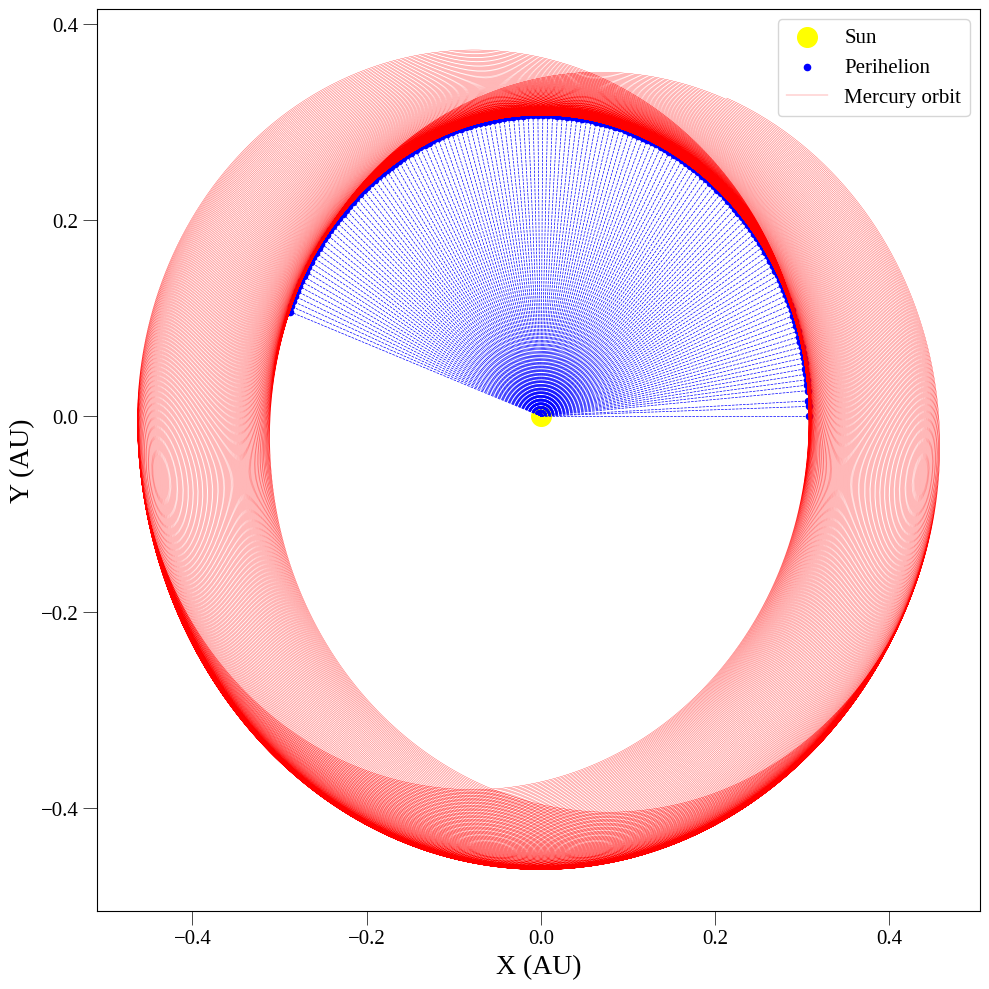

In [24]:
# Static plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('X (AU)')
ax.yaxis.label.set_fontsize(20)
ax.set_ylabel('Y (AU)')
ax.xaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
 
ax.scatter(0, 0, c='yellow', marker='o', s=200, label='Sun')

ax.scatter(perihelion_positions[:, 0] / AU, perihelion_positions[:, 1] / AU, c='b', marker='o', s=20, label='Perihelion')

for pos in perihelion_positions:
    ax.plot([0, pos[0] / AU], [0, pos[1] / AU], 'b--', linewidth=0.5)

ax.plot(r[:, 0] / AU, r[:, 1] / AU, 'r', linewidth=0.2, label='Mercury orbit')

ax.legend(fontsize=15)

plt.tight_layout() 
plt.savefig(f'images/orbit_{alpha}_{beta}_{N_T}_{N_dt}.png', bbox_inches='tight')
plt.show()

Calculaaaaaating:   0%|          | 0/10 [00:00<?, ?it/s]

Calculaaaaaating: 100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


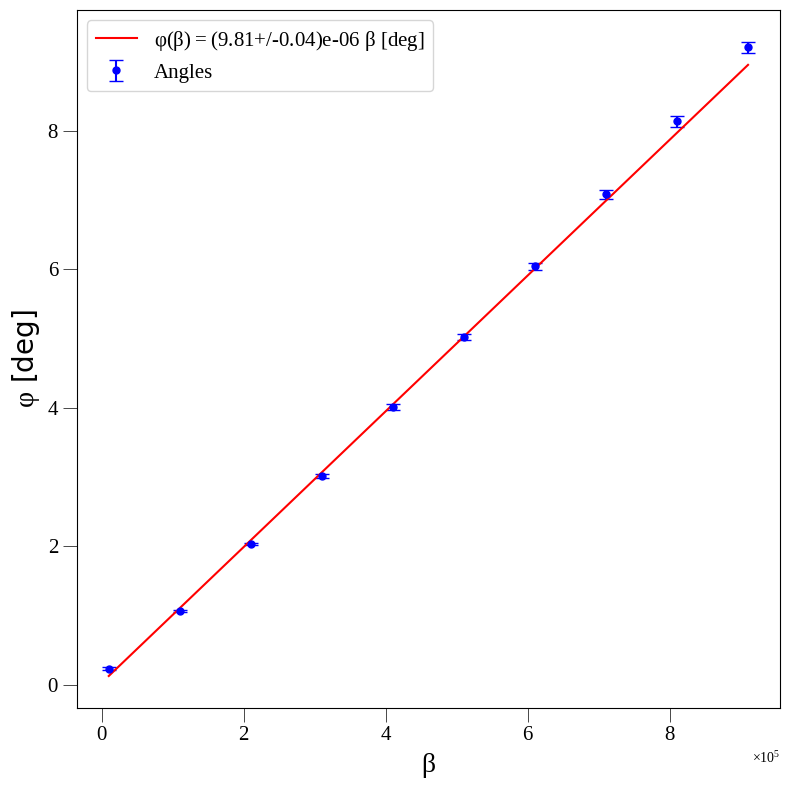

Calculaaaaaating: 100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


In [8]:
# Getting data for the plot diff phi vs beta
phi_alpha_10, angles_alpha_10, beta_range_10 = getting_angle_data('alpha', 10**4, 10**6, 10**5, N_T, 10, plot=False)
phi_alpha_50, angles_alpha_50, beta_range_50 = getting_angle_data('alpha', 10**4, 10**6, 10**5, N_T, 50, plot=False)
phi_alpha_100, angles_alpha_100, beta_range_100 = getting_angle_data('alpha', 10**4, 10**6, 10**5, N_T, 100, plot=False)
phi_alpha_200, angles_alpha_200, beta_range_200 = getting_angle_data('alpha', 10**4, 10**6, 10**5, N_T, 200, plot=True)
phi_alpha_500, angles_alpha_500, beta_range_500 = getting_angle_data('alpha', 10**4, 10**6, 10**5, N_T, 500, plot=False)

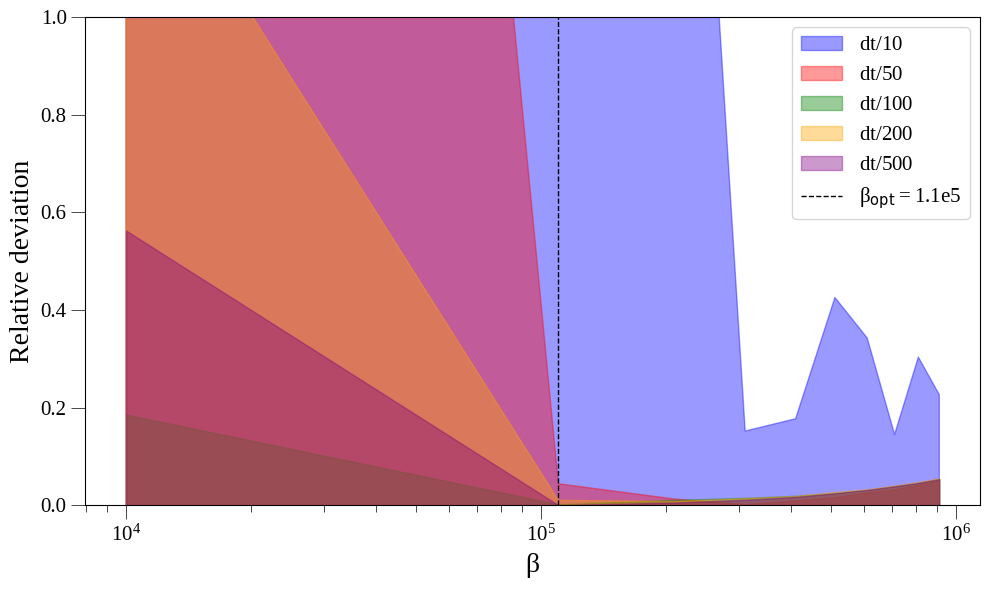

In [9]:
# Plotting the difference for phi vs beta
plotting_difference('beta', [angles_alpha_10, angles_alpha_50, angles_alpha_100, angles_alpha_200, angles_alpha_500], [beta_range_10, beta_range_50, beta_range_100, beta_range_200, beta_range_500], [10, 50, 100, 200, 500])

Calculaaaaaating:   0%|          | 0/10 [00:00<?, ?it/s]

Calculaaaaaating: 100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


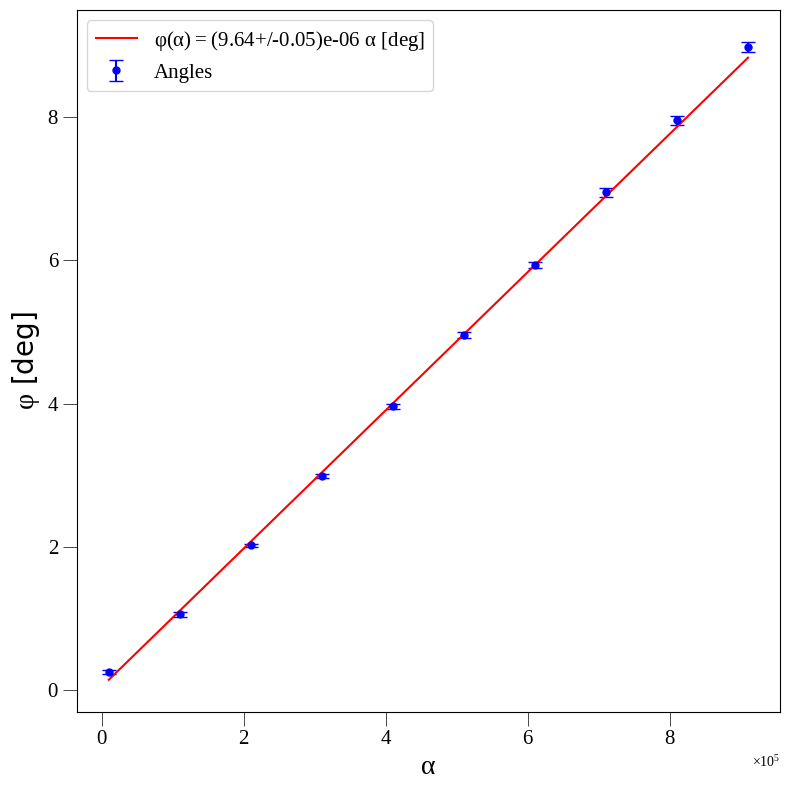

Calculaaaaaating: 100%|██████████| 10/10 [01:46<00:00, 10.68s/it]


In [10]:
# Getting data for the plot diff phi vs alpha
phi_beta_10, angles_beta_10, alpha_range_10 = getting_angle_data('beta', 10**4, 10**6, 10**5, N_T, 10, plot=False)
phi_beta_50, angles_beta_50, alpha_range_50 = getting_angle_data('beta', 10**4, 10**6, 10**5, N_T, 50, plot=False)
phi_beta_100, angles_beta_100, alpha_range_100 = getting_angle_data('beta', 10**4, 10**6, 10**5, N_T, 100, plot=False)
phi_beta_200, angles_beta_200, alpha_range_200 = getting_angle_data('beta', 10**4, 10**6, 10**5, N_T, 200, plot=True)
phi_beta_500, angles_beta_500, alpha_range_500 = getting_angle_data('beta', 10**4, 10**6, 10**5, N_T, 500, plot=False)

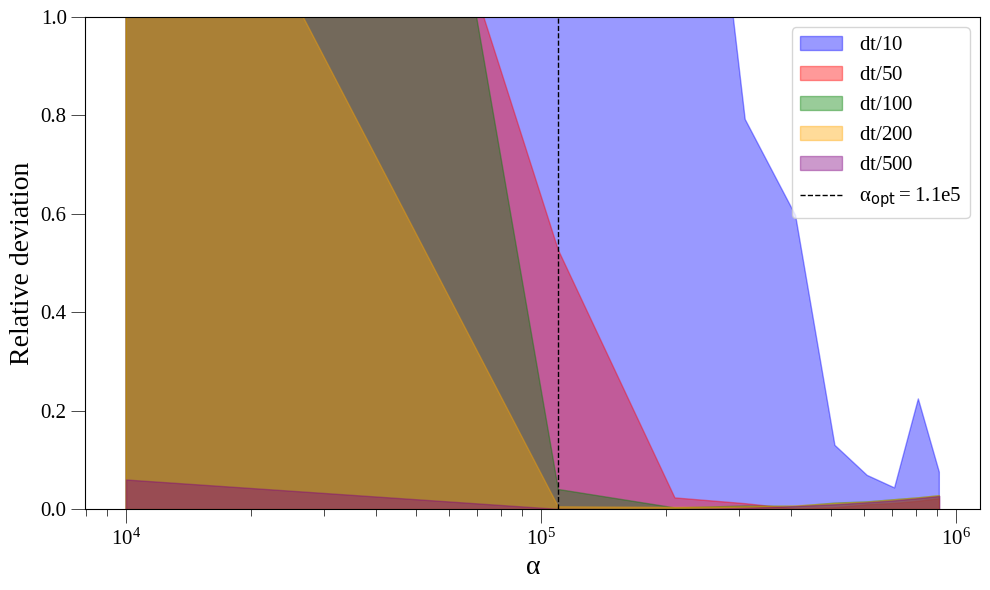

In [11]:
# Plotting the difference for phi vs alpha
plotting_difference('alpha', [angles_beta_10, angles_beta_50, angles_beta_100, angles_beta_200, angles_beta_500], [alpha_range_10, alpha_range_50, alpha_range_100, alpha_range_200, alpha_range_500], [10, 50, 100, 200, 500])

In [ ]:
N_T_list = list(range(10, 151, 10))
N_dt_list = list(range(10, 301, 10))

# # uncomment of you want to run the efficency test
# deviations_val, deviations_err, times = efficency_test(alpha, beta, N_T_list, N_dt_list)

# # Save efficency test data to a CSV file
# data = {
#     'deviations_val': deviations_val.flatten(),
#     'deviations_err': deviations_err.flatten(),
#     'times': times.flatten()
# } 

# df = pd.DataFrame(data)

# df.to_csv('output/efficency_test_data.csv', index=False)

Processing N_T: 100%|██████████| 15/15 [21:14<00:00, 84.97s/it] 


In [26]:
# efficency test takes a long time to run, so we will load the data from the file
deviations_val = pd.read_csv('output/efficency_test_data.csv')['deviations_val'].values.reshape((15, 30))
deviations_err = pd.read_csv('output/efficency_test_data.csv')['deviations_err'].values.reshape((15, 30))
times = pd.read_csv('output/efficency_test_data.csv')['times'].values.reshape((15, 30))

Global minima at N_dt = 150, N_T = 150 with value = 0.003415881351721869
Local minima at N_dt = 150, N_T = 90 with value = 0.006639733417385799


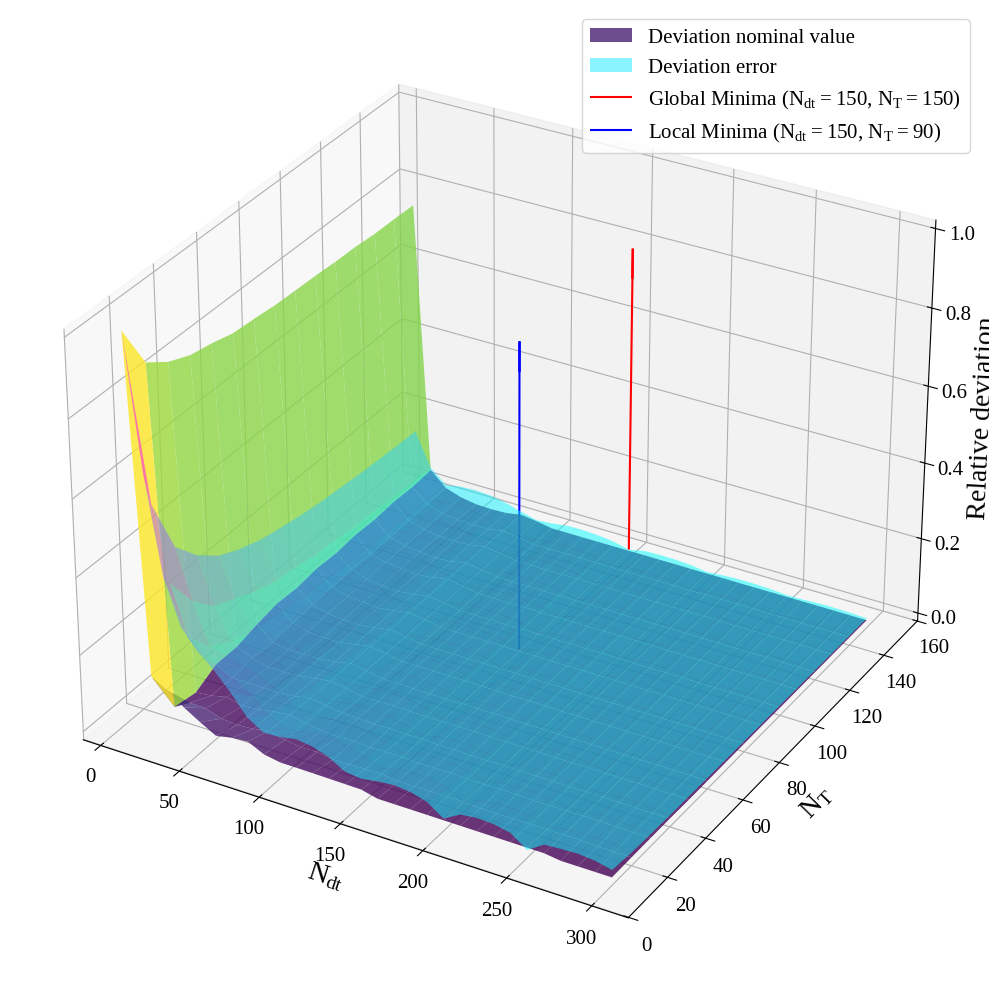

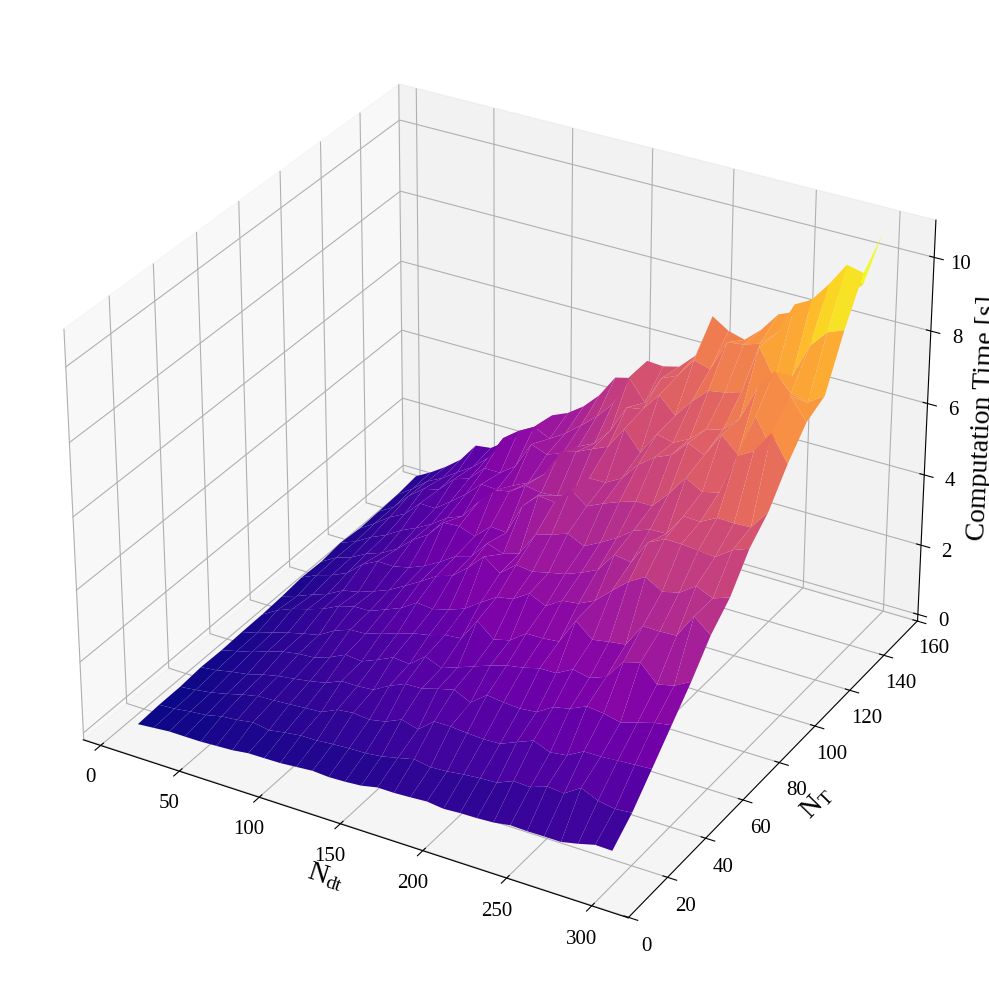

In [27]:
# 3D Analysis Visualization
X, Y = np.meshgrid(N_dt_list, N_T_list)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(rf"$N_{{dt}}$")
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(rf"$N_{{T}}$")
ax.yaxis.label.set_fontsize(20)
ax.set_zlabel("Relative deviation")
ax.zaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)

# Normalize deviations_val and deviations_err
normalized_deviations_val = (deviations_val - np.min(deviations_val)) / (np.max(deviations_val) - np.min(deviations_val))
normalized_deviations_err = (deviations_err - np.min(deviations_err)) / (np.max(deviations_err) - np.min(deviations_err))
# normalized_times = (times - np.min(times)) / (np.max(times) - np.min(times))

# Combine normalized deviations_val and deviations_err surfaces
combined_surface = normalized_deviations_val + normalized_deviations_err #+ normalized_times

ax.plot_surface(X, Y, normalized_deviations_val, cmap='viridis', alpha=0.8, label='Deviation nominal value')
ax.plot_surface(X, Y, normalized_deviations_err, cmap='cool', alpha=0.5, label='Deviation error')
# ax.plot_surface(X, Y, normalized_times, cmap='plasma', alpha=0.5, label='Computation time')
# ax.plot_surface(X, Y, combined_surface, cmap='viridis', alpha=0.8)

# Find global minima on the combined surface
global_min_index = np.unravel_index(np.argmin(combined_surface, axis=None), combined_surface.shape)
global_min_value = combined_surface[global_min_index]

ax.quiver(X[global_min_index], Y[global_min_index], global_min_value, 0, 0, 0.8, color='red', arrow_length_ratio=0.1, label=rf'Global Minima ($N_{{dt}}={X[global_min_index]}$, $N_{{T}}={Y[global_min_index]}$)')

print(f"Global minima at N_dt = {X[global_min_index]}, N_T = {Y[global_min_index]} with value = {global_min_value}")

# Find global minima in the range
x_range, y_range = 200, 100
mask = (X < x_range) & (Y < y_range)
masked_surface = np.ma.masked_array(combined_surface, mask=~mask)
local_min_index = np.unravel_index(np.argmin(masked_surface, axis=None), masked_surface.shape)
local_min_value = combined_surface[local_min_index]

ax.quiver(X[local_min_index], Y[local_min_index], local_min_value, 0, 0, 0.8, color='blue', arrow_length_ratio=0.1, label=rf'Local Minima ($N_{{dt}}={X[local_min_index]}$, $N_{{T}}={Y[local_min_index]}$)')

print(f"Local minima at N_dt = {X[local_min_index]}, N_T = {Y[local_min_index]} with value = {local_min_value}")

ax.legend(fontsize=15)

plt.tight_layout()
plt.savefig(f'images/3d_deviation.png', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(rf"$N_{{dt}}$")
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(rf"$N_{{T}}$")
ax.yaxis.label.set_fontsize(20)
ax.set_zlabel("Computation Time [s]")
ax.zaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)

ax.plot_surface(X, Y, times, cmap='plasma')

plt.tight_layout()
plt.savefig(f'images/3d_time.png', bbox_inches='tight')
plt.show()